# Demo notebook for analyzing the Terraclimate dataset

This notebook provides an example of accessing the Terraclimate dataset. This example will show you how temperature has increased over the past 60 years across the entire United States.

TerraClimate is a dataset of monthly climate and climatic water balance for global terrestrial surfaces from 1958-2019. These data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data. All data have monthly temporal resolution and a ~4-km (1/24th degree) spatial resolution. The data cover the period from 1958-2019.

In [1]:
import xarray as xr
import zarr
import os
import fsspec

In [8]:
# mapper = zarr.storage.ABSStore(
#         'carbonplan-data',
#         prefix='raw/terraclimate/4000m/raster.zarr',
#         account_name="carbonplan",
#         account_key=os.environ["BLOB_ACCOUNT_KEY"])

In [52]:
mapper = fsspec.get_mapper('az://carbonplan-data/raw/terraclimate/4000m/raster.zarr'
                           'terraclimate_plus.zarr', 
                           account_name='carbonplan')

In [2]:
mapper = fsspec.get_mapper('az://carbonplan-downscaling/obs/conus/4000m/monthly/'
                           'terraclimate_plus.zarr', 
                           account_name='carbonplan')

Open the file using `zarr`. The consolidated flag will speed it up a bit.

In [53]:
ds = xr.open_zarr(mapper, consolidated=True)
ds.x.attrs['units'] = 'm'
ds.y.attrs['units'] = 'm'

KeyError: '.zmetadata'

Check out the dataset to see the components that you can work with. There are three coordinates (time, x, y) and twenty different variables which can be accessed via those coordinates. Some of the variables vary over time (e.g. temperature, precipitation, evaporation), while others are constant through time (e.g. elevation, a domain mask). We can access this lazily without actually loading the file into memory.

In [7]:
ds

<xarray.Dataset>
Dimensions:    (time: 744, x: 1209, y: 783)
Coordinates:
    lat        (y, x) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    lon        (y, x) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
  * time       (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2019-12-01
  * x          (x) float64 -2.491e+06 -2.487e+06 ... 2.337e+06 2.341e+06
  * y          (y) float64 3.308e+06 3.304e+06 3.3e+06 ... 1.84e+05 1.8e+05
Data variables:
    aet        (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>
    awc        (y, x) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    def        (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>
    elevation  (y, x) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    mask       (y, x) int64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    pdsi       (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>
    pet        (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>
    ppt        (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>
    q          (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>
    rh         (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>
    soil       (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>
    srad       (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>
    swe        (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>
    tdew       (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>
    tmax       (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>
    tmean      (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>
    tmin       (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>
    vap        (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>
    vpd        (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>
    ws         (time, y, x) float32 dask.array<chunksize=(744, 50, 50), meta=np.ndarray>

Let's see how temperature has changed over the observational record, when averaged across the entire domain. Since we'll do some other calculations below we'll also add `.compute()` to execute the command instead of specifying it lazily.

In [17]:
temperature = ds.tmax.mean(dim=['x', 'y']).compute()

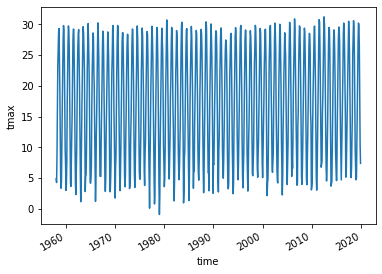

In [19]:
temperature.plot()

With all the seasonal fluctuations (from summer and winter) though, it can be hard to see any obvious trends. So let's try grouping by year and plotting that timeseries.

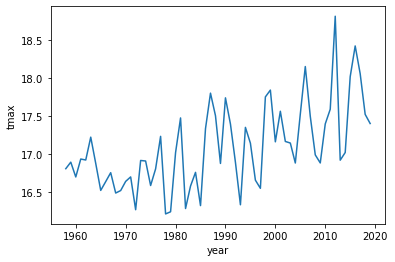

In [21]:
temperature.groupby('time.year').mean().plot()

Wow, so the increase in temperature really is obvious, even when averaged across the entire United States domain.

Now, let's see how those changes are different in different parts of the country. And let's focus just on summer months, when it's hottest. Let's take a climatological slice at the beginning of the period and the same at the end of the period, calculate the difference, and map it to see how different parts of the country have changed differently.

First we'll just grab the summer months.

In [46]:
summer_months=[6,7,8]
ds = ds.tmax.where(ds.time.dt.month.isin(summer_months), drop=True)

In [47]:
early_period = slice('1958-01-01', '1988-12-31')
late_period = slice('1988-01-01', '2018-12-31')

In [48]:
early = ds.sel(time=early_period).mean(dim='time').compute()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [49]:
late = ds.sel(time=late_period).mean(dim='time').compute()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


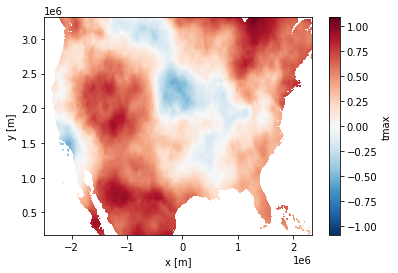

In [51]:
(late-early).plot()

Interesting, so the changes in summer temperature haven't been felt equally around the country. The Southwest has felt the strongest temperature increases, particluarly along the US/Mexico border.